In [115]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.datasets as dset
from imageio import imread
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
# from model.nms.nms_wrapper import nms
from model.roi_layers import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.utils.blob import im_list_to_blob
from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet
import pdb

try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3

In [116]:
image_path = 'data/VOCdevkit2012/VOC2012/JPEGImages/2012_004331.jpg'

In [117]:
lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY

def _get_image_blob(im):
    """Converts an image into a network input.
    Arguments:
      im (ndarray): a color image in BGR order
    Returns:
      blob (ndarray): a data blob holding an image pyramid
      im_scale_factors (list): list of image scales (relative to im) used
        in the image pyramid
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        # Prevent the biggest axis from being more than MAX_SIZE
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)

    # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)

In [118]:
net='vgg16'
dataset='pascal_voc_0712'
load_dir='models'

cfg_file='cfgs/{}.yml'.format(net)
set_cfgs=None
cuda=torch.cuda.is_available()


# checkpoint to use
session=11
epoch=7
checkpoint=3723

class_agnostic=False
image_dir='images'
vis=True

In [119]:
if cfg_file is not None:
    cfg_from_file(cfg_file)
if set_cfgs is not None:
    cfg_from_list(set_cfgs)

cfg.USE_GPU_NMS = cuda

print('Using config:')
#pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)

# train set
# -- Note: Use validation set and disable the flipped to enable faster loading.

input_dir = load_dir + "/" + net + "/" + dataset
if not os.path.exists(input_dir):
    raise Exception('There is no input directory for loading network from ' + input_dir)
load_name = os.path.join(input_dir,
    'faster_rcnn_{}_{}_{}.pth'.format(session, epoch, checkpoint))

pascal_classes = np.asarray(['__background__',
                       'aeroplane', 'bicycle', 'bird', 'boat',
                       'bottle', 'bus', 'car', 'cat', 'chair',
                       'cow', 'diningtable', 'dog', 'horse',
                       'motorbike', 'person', 'pottedplant',
                       'sheep', 'sofa', 'train', 'tvmonitor'])

Using config:


In [120]:
# initilize the network here.
if net == 'vgg16':
    fasterRCNN = vgg16(pascal_classes, pretrained=False, class_agnostic=class_agnostic)
elif net == 'res101':
    fasterRCNN = resnet(pascal_classes, 101, pretrained=False, class_agnostic=class_agnostic)
elif net == 'res50':
    fasterRCNN = resnet(pascal_classes, 50, pretrained=False, class_agnostic=class_agnostic)
elif net == 'res152':
    fasterRCNN = resnet(pascal_classes, 152, pretrained=False, class_agnostic=class_agnostic)
else:
    print("network is not defined")
    pdb.set_trace()

fasterRCNN.create_architecture()

In [121]:
print("load checkpoint %s" % (load_name))
if cuda > 0:
    checkpoint = torch.load(load_name)
else:
    checkpoint = torch.load(load_name, map_location=(lambda storage, loc: storage))
fasterRCNN.load_state_dict(checkpoint['model'])
if 'pooling_mode' in checkpoint.keys():
    cfg.POOLING_MODE = checkpoint['pooling_mode']


print('load model successfully!')

# pdb.set_trace()

# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)

# ship to cuda
if cuda > 0:
    im_data = im_data.cuda()
    im_info = im_info.cuda()
    num_boxes = num_boxes.cuda()
    gt_boxes = gt_boxes.cuda()

# make variable
im_data = Variable(im_data, volatile=True)
im_info = Variable(im_info, volatile=True)
num_boxes = Variable(num_boxes, volatile=True)
gt_boxes = Variable(gt_boxes, volatile=True)

if cuda > 0:
    cfg.CUDA = True

if cuda > 0:
    fasterRCNN.cuda()

load checkpoint models/vgg16/pascal_voc_0712/faster_rcnn_11_7_3723.pth
load model successfully!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [122]:
fasterRCNN.eval()

start = time.time()
max_per_image = 100
thresh = 0.05
vis = True


from os import listdir
from os.path import isfile, join

imglist = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]
imglist = [image_path]
num_images = len(imglist)


print('Loaded Photo: {} images.'.format(num_images))

Loaded Photo: 1 images.


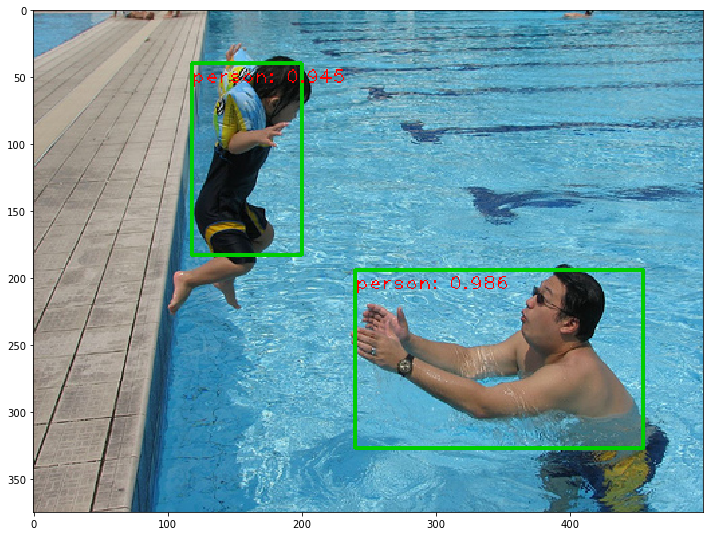

image_det.jpg


In [123]:
while (num_images > 0):
    total_tic = time.time()
    num_images -= 1

    # Load the demo image
    im_file = imglist[num_images]
    # im = cv2.imread(im_file)
    im_in = np.array(imread(im_file, format="JPEG"))
    if len(im_in.shape) == 2:
        im_in = im_in[:,:,np.newaxis]
        im_in = np.concatenate((im_in,im_in,im_in), axis=2)
    # rgb -> bgr
    im = im_in[:,:,::-1]

    blobs, im_scales = _get_image_blob(im)
    assert len(im_scales) == 1, "Only single-image batch implemented"
    im_blob = blobs
    im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    with torch.no_grad():
        im_data.resize_(im_data_pt.size()).copy_(im_data_pt)
        im_info.resize_(im_info_pt.size()).copy_(im_info_pt)
        gt_boxes.resize_(1, 1, 5).zero_()
        num_boxes.resize_(1).zero_()

    # pdb.set_trace()
    det_tic = time.time()

    rois, cls_prob, bbox_pred, \
        rpn_loss_cls, rpn_loss_box, \
        RCNN_loss_cls, RCNN_loss_bbox, \
        rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]

    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred.data
        if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Optionally normalize targets by a precomputed mean and stdev
            if class_agnostic:
                if cuda > 0:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                else:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)

                box_deltas = box_deltas.view(1, -1, 4)
            else:
                if cuda > 0:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                else:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)
                box_deltas = box_deltas.view(1, -1, 4 * len(pascal_classes))

        pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
        pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))

    pred_boxes /= im_scales[0]

    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()
    det_toc = time.time()
    detect_time = det_toc - det_tic
    misc_tic = time.time()
    if vis:
        im2show = np.copy(im)
    for j in xrange(1, len(pascal_classes)):
        inds = torch.nonzero(scores[:,j]>thresh).view(-1)
        # if there is det
        if inds.numel() > 0:
            cls_scores = scores[:,j][inds]
            _, order = torch.sort(cls_scores, 0, True)
            if class_agnostic:
                cls_boxes = pred_boxes[inds, :]
            else:
                cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]
            
            cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
            # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
            cls_dets = cls_dets[order]
            # keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
            keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
            cls_dets = cls_dets[keep.view(-1).long()]
            if vis:
                im2show = vis_detections(im2show, pascal_classes[j], cls_dets.cpu().numpy(), 0.5)

    misc_toc = time.time()
    nms_time = misc_toc - misc_tic

    sys.stdout.write('im_detect: {:d}/{:d} {:.3f}s {:.3f}s name: {}   \r' \
                           .format(num_images + 1, len(imglist), detect_time, nms_time, im_file))
    
    if vis:
        plt.figure(figsize=(12,12))
        plt.imshow(cv2.cvtColor(im2show, cv2.COLOR_BGR2RGB))
        plt.show()
        result_path = os.path.join("image_det.jpg")
        print(result_path)
        cv2.imwrite(result_path, im2show)